In [1]:
#from functools import partial

import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam

#from nets import freeze_layers, get_model_from_name
from utils.callbacks import (ExponentDecayScheduler, LossHistory,
                             ModelCheckpoint)
from utils.dataloader import ClsDatasets
from utils.utils import get_classes
#from utils.utils_fit import fit_one_epoch

In [2]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# 获取数据路径，并划分训练集和测试集数量

# 测试集的地址，我要把全部合在一起

In [8]:
annotation_path = "path_txt//test_stable/train_val.txt"

with open(annotation_path, "r") as f:
    lines_test = f.readlines()

In [9]:
lines_test_0 = lines_test[:436]
lines_test_1 = lines_test[436:556]
lines_test_2 = lines_test[556:752]
lines_test_3 = lines_test[752:]

In [10]:
np.random.seed(10101)
np.random.shuffle(lines_test_0)
np.random.shuffle(lines_test_1)
np.random.shuffle(lines_test_2)
np.random.shuffle(lines_test_3)
np.random.seed(None)

# 训练级的地址

In [3]:
classes_path = 'path_txt/cls_classes.txt'
class_names, num_classes = get_classes(classes_path) #得到类别与种类个数

In [4]:
class_names

['Retinopathy_grade_0',
 'Retinopathy_grade_1',
 'Retinopathy_grade_2',
 'Retinopathy_grade_3']

In [5]:
annotation_path = "path_txt/test_stable/train_val.txt"
val_split       = 0.2

with open(annotation_path, "r") as f:
    lines = f.readlines()
    
# np.random.seed(10101)
# np.random.shuffle(lines)
# np.random.seed(None)
# num_val     = int(len(lines) * val_split)
# num_train   = len(lines) - num_val

In [6]:
len(lines)

3338

# 不同种类的地址

In [7]:
lines_0 = lines[:1050]

In [8]:
#lines_0[-1]

In [9]:
lines_1 = lines[1050:1737]

In [10]:
#lines_1[-1]

In [11]:
lines_2 = lines[1737:2525]

In [12]:
#lines_2[-1]

In [13]:
lines_3 = lines[2525:]

In [14]:
len(lines_0) + len(lines_1) +len(lines_2) + len(lines_3)

3338

In [15]:
import numpy as np

np.random.seed(10101)
np.random.shuffle(lines_0)
np.random.shuffle(lines_1)
np.random.shuffle(lines_2)
np.random.shuffle(lines_3)
np.random.seed(None)

In [16]:
#lines = [lines_0, lines_1, lines_2, lines_3]
lines = [lines_0, lines_1, lines_2, lines_3]

In [17]:
train_path = []
val_path = []

for i in range(4):
    line = lines[i]
    N = len(line)
    num_val     = int(N * val_split)
    num_train   = N - num_val
    for j in range(N):
        if j+1<=num_val:
            val_path.append(line[j])
        else:
            train_path.append(line[j])

In [18]:
num_train = len(train_path)
num_val = len(val_path)

In [19]:
np.random.seed(2022)
np.random.shuffle(train_path)
np.random.shuffle(val_path)
np.random.seed(None)

In [20]:
annotation_path = "path_txt/test_stable/test.txt"

with open(annotation_path, "r") as f:
    test_path = f.readlines()

In [21]:
num_train

2672

In [22]:
num_val

666

In [23]:
len(test_path)

832

In [18]:
train_path = []
val_path = []

for i in range(4):
    line = lines[i]
    N = len(line)
    num_val     = int(N * val_split)
    num_train   = N - num_val
    for j in range(N):
        if j+1<=num_val:
            val_path.append(line[j])
        else:
            train_path.append(line[j])

In [26]:
len(train_path)

2506

In [27]:
len(val_path)

832

In [28]:
len(test_path)

832

In [29]:
num_train = len(train_path)
num_val = len(val_path)

In [30]:
np.random.seed(2022)
np.random.shuffle(train_path)
np.random.shuffle(val_path)
np.random.seed(None)

# 模型

In [24]:
from tensorflow.keras.layers import (Dense,Input,GlobalAveragePooling2D)
from tensorflow.keras.models import Model
from tensorflow.keras import applications

def resnet101(input_shape=None):
    net = applications.ResNet101(include_top=False,input_shape=input_shape,weights=None)

    return net

def ResNet101(input_shape=[224,224,3],classes=4):
    img_input = Input(input_shape)

    x = resnet101(input_shape)(img_input)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256)(x)
    x = Dense(256)(x)
    x = Dense(classes,activation='softmax', name='fc1000')(x)
    x = Model(img_input, x, name='ResNet101')
    return x

In [25]:
model = ResNet101(input_shape=[224,224,3],classes=4)
#model.summary()
#model.load_weights('D:\class_PR\classification-tf2-main\logs\with_dict-ep015-loss0.060-val_loss0.509.h5')
#model.load_weights(r'test_acc-0.87-resnet101.h5')

In [26]:
model.load_weights('resnet101_four.h5')
#model.load_weights('D:\class_PR\ju\weights\\test_acc-0.65-balance-resnet101.h5')

In [39]:
model.load_weights('D:\class_PR\ju\\weights\\cls_4\\4cls_0.88-ep010-loss0.098-val_loss0.244.h5')  #加载这个

In [27]:
for i in range(2):
    model.layers[i].trainable = True

# 回调函数

In [28]:
logging         = TensorBoard(log_dir = 'logs/')
checkpoint      = ModelCheckpoint('logs/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
                                    monitor='val_loss', save_weights_only=True, save_best_only=False, period=5)
reduce_lr       = ExponentDecayScheduler(decay_rate = 0.95, verbose = 1)
early_stopping  = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)
loss_history    = LossHistory('logs/')
#tf.keras.callbacks.ModelCheckpoint()

In [29]:
batch_size      = 16
Lr              = 1e-4
Init_Epoch      = 0
Epoch           = 100
input_shape     = [224, 224]
num_workers     = 1

epoch_step          = num_train // batch_size
epoch_step_val      = num_val // batch_size

if epoch_step == 0 or epoch_step_val == 0:
    raise ValueError('数据集过小，无法进行训练，请扩充数据集。')
            
print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))

Train on 2672 samples, val on 666 samples, with batch size 16.


In [30]:
train_dataloader    = ClsDatasets(train_path, input_shape, batch_size, num_classes, train = True)
val_dataloader      = ClsDatasets(val_path, input_shape, batch_size, num_classes, train = False)

# 得到tf的data train

In [41]:
x_train = []
y_train =[]

for x,y in train_dataloader:
    x_train.append(x)
    y_train.append(np.argmax(y,axis=1))

In [53]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

In [55]:
x_train = np.squeeze(x_train, 1)
y_train = np.squeeze(y_train, 1)

In [56]:
x_train[0].shape

(224, 224, 3)

In [57]:
y_train[0].shape

()

In [75]:
train_data2 = tf.data.Dataset.from_tensor_slices((x_train, y_train))

In [76]:
train_data2

<TensorSliceDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>

In [77]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data2 = train_data2.shuffle(buffer_size=num_train)#.repeat(-1)
train_data2 = train_data2.batch(batch_size)
train_data2 = train_data2.prefetch(buffer_size=AUTOTUNE)

In [78]:
train_data2

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [42]:
#for x,y in val_dataloader:
#    print(y)

# 得到tf的data val

In [66]:
x_val = []
y_val =[]

for x,y in val_dataloader:
    x_val.append(x)
    y_val.append(np.argmax(y,axis=1))

In [67]:
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)

In [68]:
x_val = np.squeeze(x_val, 1)
y_val = np.squeeze(y_val, 1)

In [69]:
val_data1 = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [70]:
val_data1 = val_data1.batch(batch_size)

In [71]:
val_data1

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [72]:
lr_schedule     = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=Lr, decay_steps=epoch_step, decay_rate=0.95, staircase=True
            )
optimizer       = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=["acc"])

In [79]:
model.fit(train_data2,
         validation_data     = val_data1,
        validation_steps    = epoch_step_val,
        epochs              = Epoch,
        initial_epoch       = Init_Epoch,
        use_multiprocessing = True if num_workers > 1 else False,
        workers             = num_workers,
        callbacks           = [logging, checkpoint, early_stopping, loss_history],
    #class_weight= cls_wt_dict
    )

Epoch 1/100


ValueError: in user code:

    d:\miniconda\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    d:\miniconda\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    d:\miniconda\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    d:\miniconda\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    d:\miniconda\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    d:\miniconda\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    d:\miniconda\lib\site-packages\tensorflow\python\keras\engine\training.py:749 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    d:\miniconda\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    d:\miniconda\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    d:\miniconda\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    d:\miniconda\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    d:\miniconda\lib\site-packages\tensorflow\python\keras\losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    d:\miniconda\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    d:\miniconda\lib\site-packages\tensorflow\python\keras\backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    d:\miniconda\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 4) are incompatible


# 类别的权重

In [42]:
#cls_wt_dict = {0: 0.5490867579908676, 1: 1.9552845528455285, 2: 1.2208121827411167, 3: 1.178921568627451}
#cls_wt_dict = {0: 0.8481735159817352, 1: 1.5101626016260163, 2: 0.9428934010152284, 3: 0.9105392156862745} #balance
cls_wt_dict = {0: 0.91837899543379, 1: 1.0901084010840107, 2: 1.0209390862944163, 3: 0.9859068627450981}

In [31]:
model.compile(loss = 'categorical_crossentropy',
                    optimizer = Adam(lr = Lr),
                    metrics = ['categorical_accuracy'])
            
model.fit_generator(
    generator           = train_dataloader,
    steps_per_epoch     = epoch_step,
    validation_data     = val_dataloader,
    validation_steps    = epoch_step_val,
    epochs              = Epoch,
    initial_epoch       = Init_Epoch,
    use_multiprocessing = True if num_workers > 1 else False,
    workers             = num_workers,
    callbacks           = [logging, checkpoint, reduce_lr, early_stopping, loss_history]
    #class_weight= cls_wt_dict
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
  1/167 [..............................] - ETA: 0s - loss: 1.8800 - categorical_accuracy: 0.2500WARNING:tensorflow:From d:\miniconda\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
167/167 [==============================] - 144s 863ms/step - loss: 1.1767 - categorical_accuracy: 0.5228 - val_loss: 1.7318 - val_categorical_accuracy: 0.2088
Epoch 2/100
167/167 [==============================] - 117s 700ms/step - loss: 0.8693 - categorical_accuracy: 0.6261 - val_loss: 1.4247 - val_categorical_accuracy: 0.3110
Epoch 3/100
167/167 [==============================] - 120s 716ms/step - loss: 0.7768 - categorical_accuracy: 0.6692 - val_loss: 1.4623 - val_categorical_accuracy: 0.3628
Epoch 4/100
167/167 [========================

# 下面是画混淆矩阵用的

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from matplotlib import pyplot as plt
%matplotlib inline

# borrowed from scikit learn  这个是为了画混淆矩阵
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# 合在一起后的测试

In [33]:
annotation_path = "path_txt/test_stable/test.txt"

with open(annotation_path, "r") as f:
    test_path = f.readlines()

In [34]:
val_for_test = ClsDatasets(test_path, input_shape, 1, num_classes, train = False)

x_val_for_test = []
y_val_for_test =[]

for x,y in val_for_test:
    x_val_for_test.append(x)
    y_val_for_test.append(y)

x_val_for_test = np.asarray(x_val_for_test)
y_val_for_test = np.asarray(y_val_for_test)

x_val_for_test = np.squeeze(x_val_for_test, 1)
y_val_for_test = np.squeeze(y_val_for_test, 1)

y_val_for_test_pred = model.predict(x_val_for_test)

Y_pred_val = np.argmax(y_val_for_test_pred,axis=1)
Y_actual_val = np.argmax(y_val_for_test,axis=1)

#plot_confusion_matrix(Y_actual_val, Y_pred_val, np.array(class_names))

Confusion matrix, without normalization
[[199  49  13   1]
 [ 10 158   2   1]
 [  9  17 162   8]
 [  2   3  16 182]]


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

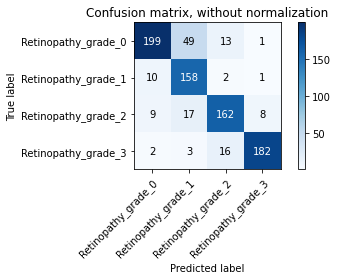

In [35]:
plot_confusion_matrix(Y_actual_val, Y_pred_val, np.array(class_names))

# 获得测试集

In [97]:
import glob

img_path = glob.glob('D:\\class_PR\\dataset\\test\\*\\*.jpg')
#img_path = glob.glob('D:\\class_PR\\preporessing_test_data\\*\\*.jpg')

In [98]:
#img_path

In [99]:
label_name = [name.split('\\')[-2] for name in img_path]

In [100]:
len(label_name)

952

In [101]:
label_to_index = dict((name, i) for (i, name) in enumerate(class_names))

In [102]:
#label_to_index

In [103]:
all_labels = [label_to_index.get(la) for la in label_name]

In [104]:
from PIL import Image

# def preprocess_image(image_path, desired_size=224):
#     im = Image.open(image_path)
#     im = im.resize((desired_size, )*2, resample=Image.BILINEAR)
#     return im

def preprocess_image(image_path, size):
    image = Image.open(image_path)
    
    iw, ih  = image.size
    w, h    = size

    scale   = min(w/iw, h/ih)
    nw      = int(iw*scale)
    nh      = int(ih*scale)

    image   = image.resize((nw,nh), Image.BICUBIC)
    new_image = Image.new('RGB', size, (128,128,128))
    new_image.paste(image, ((w-nw)//2, (h-nh)//2))

    return new_image

In [105]:
N = len(img_path)
x_test = np.empty((N, 224, 224, 3), dtype=np.float32)

for i, path in enumerate(img_path):
    x_test[i, :, :, :] = preprocess_image(path,[224,224])
    
#x_test = x_test/255.0
x_test /= 127.5
x_test -= 1.

In [106]:
y_test = tf.one_hot(all_labels,num_classes)

y_test = np.asarray(y_test)

In [107]:
y_test[0]

array([1., 0., 0., 0.], dtype=float32)

In [115]:
y_pred = model.predict(x_test)

In [61]:
weight_4class = np.asarray([0.91837899543379, 1.0901084010840107, 1.0209390862944163, 0.9859068627450981], np.float32)

In [62]:
y_pred = y_pred * weight_4class

In [63]:
#y_pred[0]

In [116]:
Y_pred_hot = np.argmax(y_pred,axis=1)
Y_actual_hot = np.argmax(y_test,axis=1)

In [110]:
Y_actual_hot[-1]

3

In [111]:
#Y_pred_hot

In [112]:
#Y_actual_hot

Confusion matrix, without normalization
[[342  25  62   7]
 [ 91   3  23   3]
 [ 43   6 111  36]
 [  6   1  33 160]]


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

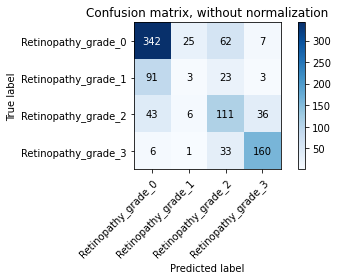

In [117]:
plot_confusion_matrix(Y_actual_hot, Y_pred_hot, np.array(class_names))

In [67]:
loss, accuracy = model.evaluate(x_test, y_test) #每个batch的
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
#print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

12/12 [==============================] - 4s 309ms/step - loss: 0.5119 - categorical_accuracy: 0.8750
Test loss: 0.51
Test accuracy: 87.5%


In [100]:
model.save_weights('test_acc-0.63-balance-resnet101.h5')

In [4]:
model.load_weights('logs/ep053-loss0.012-val_loss0.045.h5')